# CNN Classifier

- Data: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification?resource=download

In [2]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Explore data

In [3]:
data_path = '../data/'

### Visualise a butterfly from the dataset

Image size: (224, 224, 3)


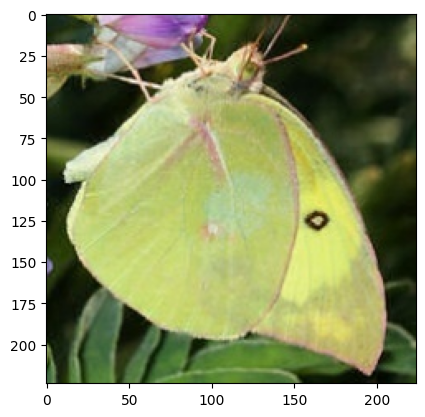

In [4]:
from PIL import Image

# Visualise image
image = np.asarray(Image.open(data_path+'train/Image_1.jpg'))
imgplot = plt.imshow(image)

print('Image size:', image.shape)
image_size = image.shape[0]

### Inspect CSV files

These files contain information of what is in the train and test folders of the data

In [5]:
train_df = pd.read_csv(data_path+'Training_set.csv')
print(train_df.shape)
train_df.head()

(6499, 2)


,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [6]:
test_df = pd.read_csv(data_path+'Testing_set.csv')
print(test_df.shape)
test_df.head()

(2786, 1)


,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


Conclusion: We'll only work with data from the train folder as data in the test folder is unlabeled.

### Visualise distribution of classes in dataset

In this way we can retrive information about how balanced the dataset is

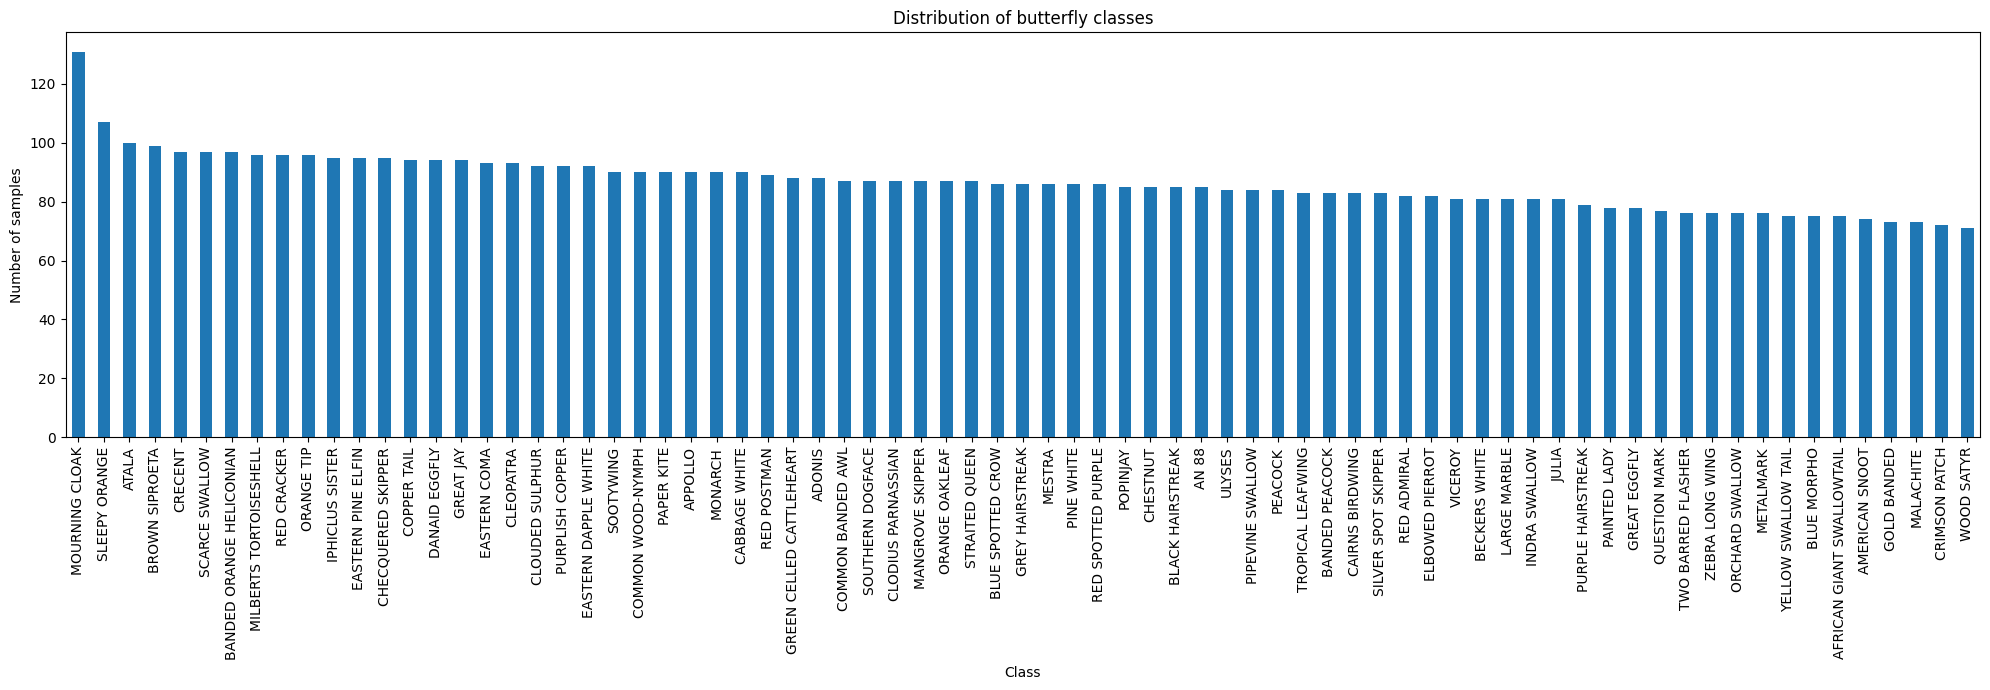

In [7]:
# Rename as we'll only use data in the train folder
data_df = train_df
data_path = data_path + 'train'

def plot_dist(df):
    # Plot distribution of butterfly classes
    plt.figure(figsize=(20, 7))
    df['label'].value_counts().plot(kind='bar')
    plt.title('Distribution of butterfly classes')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_dist(data_df)

Conclusion: Dataset is reasonably balanced, techniques for handling imbalanced datasets will not be necessary

# Preprocess data

## Split datasets

In [8]:
from sklearn.model_selection import train_test_split

# Split data into train and validation sets
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=45) # Use 20% test set size

print(train_df.shape)
print(val_df.shape)

(5199, 2)
(1300, 2)


### Check that datasets are still balanced after split

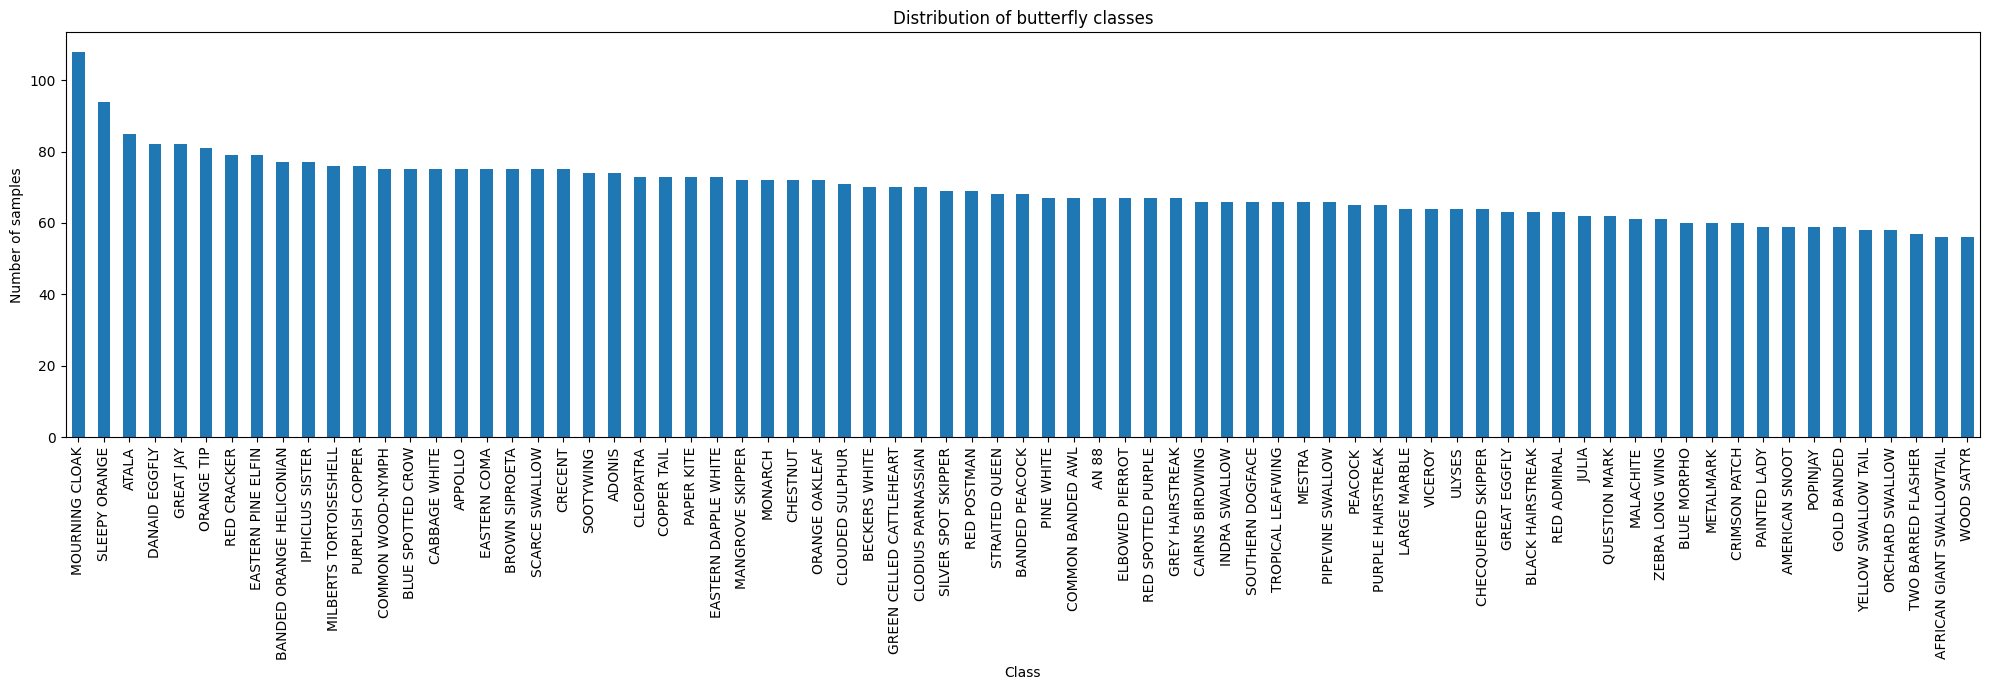

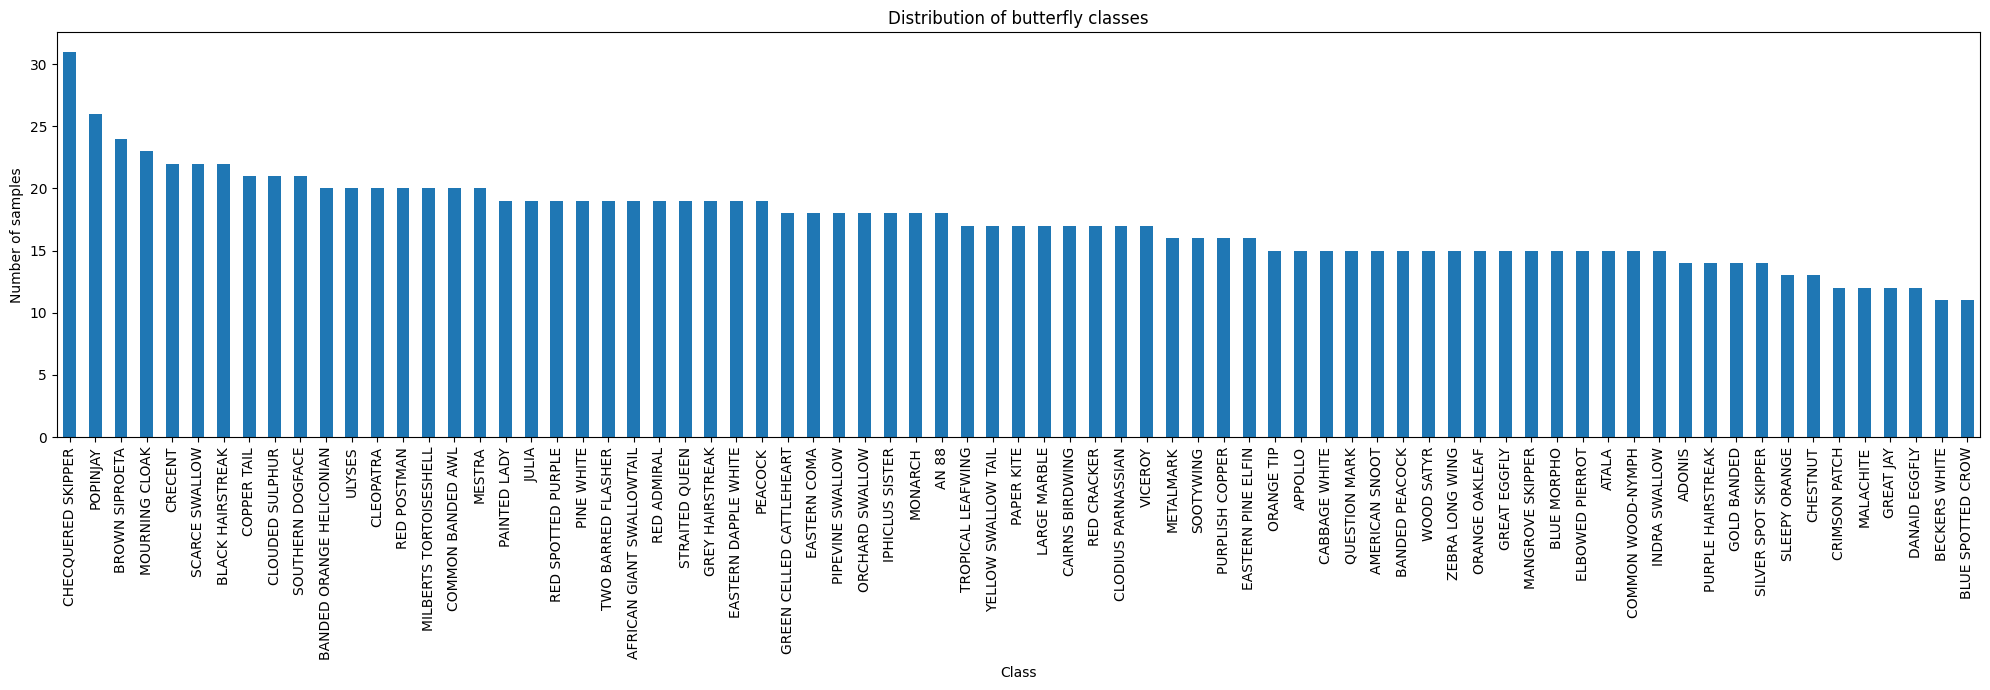

In [9]:
# Plot distribution of butterfly classes in training set
plot_dist(train_df)

# Plot distribution of butterfly classes in validation set
plot_dist(val_df)


Conslusion: They still keep the same reasonably balanced distribution

## Perform augmentation/resampling on train data

Use ImageDataGenerator for augmenting the training data, this way we resample the trainingdata to let information about patterns and shapes contained in the images be fed to the model during training in varying forms

Also normalize (rescale) all data which may help improve performance and stability of the CNN model.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size = (128, 128) # Downsize from 224 to improve training speed

# For description of args used see
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_gen = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = data_path,
    x_col ='filename',
    y_col ='label', 
    target_size = target_size,
    batch_size = batch_size,
    seed = 123,
    class_mode = 'categorical')


# Do only resclaing (normalization) of validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = data_path,
    x_col ='filename',
    y_col ='label', 
    target_size = target_size,
    batch_size = batch_size,
    seed = 123,
    class_mode = 'categorical')

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


# Construct model

Inspired by the VGG16 model, a small CNN model known for its simplicity and has shown good performance on a variety of image classification tasks

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import callbacks

input_shape = (*target_size, 3)
num_classes = 75


# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Apply early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         min_delta=0, patience=2, verbose=1, mode='auto')


# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Save train model and save its history
history = model.fit(train_gen, validation_data=val_gen, epochs=30, verbose=1, callbacks=[early_stopping])

Epoch 1/30
163/163 [==============================] - 73s 440ms/step - loss: 4.1704 - accuracy: 0.0446 - val_loss: 3.7412 - val_accuracy: 0.1454
Epoch 2/30
163/163 [==============================] - 67s 408ms/step - loss: 3.5708 - accuracy: 0.1331 - val_loss: 2.8761 - val_accuracy: 0.2454
Epoch 3/30
163/163 [==============================] - 69s 423ms/step - loss: 3.0538 - accuracy: 0.2052 - val_loss: 2.3545 - val_accuracy: 0.3808
Epoch 4/30
163/163 [==============================] - 68s 415ms/step - loss: 2.7261 - accuracy: 0.2712 - val_loss: 2.1396 - val_accuracy: 0.4462
Epoch 5/30
163/163 [==============================] - 68s 417ms/step - loss: 2.4737 - accuracy: 0.3226 - val_loss: 2.0947 - val_accuracy: 0.4415
Epoch 6/30
163/163 [==============================] - 66s 404ms/step - loss: 2.3237 - accuracy: 0.3518 - val_loss: 1.8247 - val_accuracy: 0.5185
Epoch 7/30
163/163 [==============================] - 70s 427ms/step - loss: 2.1885 - accuracy: 0.3832 - val_loss: 1.9042 - val_ac

In [14]:
# Save the entire model to a file
model.save('butterfly_classifier_CNN.keras')

In [16]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('butterfly_classifier_CNN.keras')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

### Plot training history

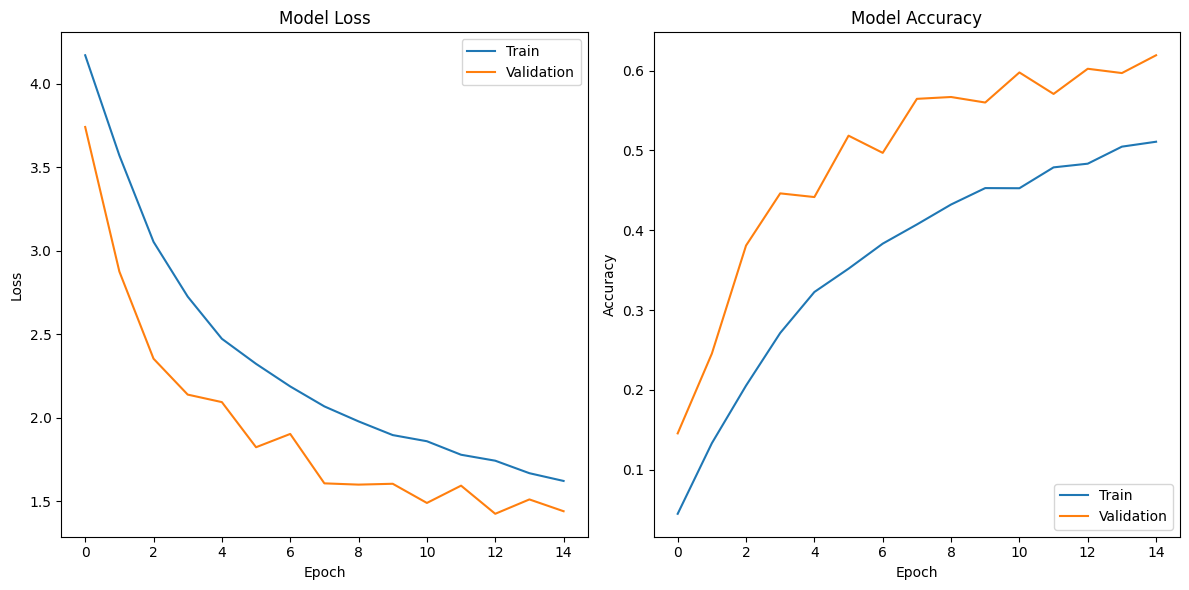

In [13]:

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

# Model interpretation

To interpret how the model thinks when predicting the class of an image Class Activation Maps (CAM) can be used. CAM is a technique that highlights the regions of an image that were most important in making a prediction. It helps to visualize which parts of the image the model focused on for a specific class.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


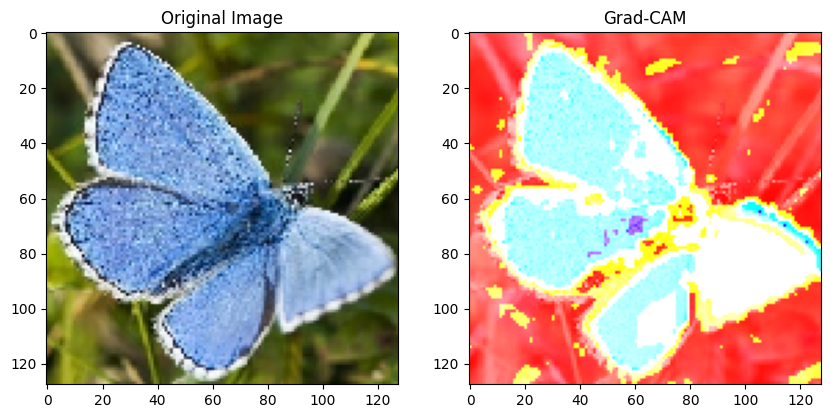

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2

# Extract the last convolutional layer for Grad-CAM
last_conv_layer = model.get_layer('conv2d_1') # Name found in model-summary

# Create a model that maps the input image to the last conv layer's output
grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

# Get the input image and preprocess it (normalize it as the model is trained on normalized images)
img_path = data_path + '/Image_2.jpg'
img = image.load_img(img_path, target_size=target_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Add dummy dimension for representing a batch
img_array /= 255.0 # Normalize

# Get the gradients of the target class with respect to the output of the last conv layer
with tf.GradientTape() as tape:
    conv_output, predictions = grad_model(img_array)
    class_idx = np.argmax(predictions[0])
    loss = predictions[:, class_idx]

# Calculate  gradients
grads = tape.gradient(loss, conv_output)[0]

# Pool the gradients over each feature map
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Multiply each feature map by its importance score (pooled gradient)
heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)

# Apply ReLU to the heatmap to focus on positive contributions
heatmap = tf.maximum(heatmap, 0)

# Normalize the heatmap
heatmap /= tf.reduce_max(heatmap)

# Convert to numpy array for visualization
heatmap = heatmap.numpy()

# Make heatmap axis be in same order as original image array
heatmap = np.moveaxis(heatmap, 0, 2)

# Upsample the heatmap to match the original image size
upsampled_heatmap = tf.image.resize(heatmap, (128, 128)).numpy()

# Superimpose the heatmap on the original image (blen original image with activation heatmap)
superimposed_img = np.uint8(255 * upsampled_heatmap)
superimposed_img = cv2.applyColorMap(superimposed_img, cv2.COLORMAP_JET)
superimposed_img = superimposed_img.astype('float32')

color_mapped_img = cv2.cvtColor(img_array[0,:,:,:], cv2.COLOR_RGB2BGR)
superimposed_img = cv2.addWeighted(color_mapped_img, 0.8, superimposed_img, 0.3, 0)

# Plot the original image and the superimposed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Grad-CAM')

plt.show()